### 图像查找


In [6]:
import cv2
import numpy as np


img1 = cv2.imread('opencv_search.png')
img2 = cv2.imread('opencv_orig.png')
g1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
g2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#创建特征检测器
sift = cv2.SIFT_create()

# 计算特征点和描述子
kp1, des1 = sift.detectAndCompute(g1, None)
kp2, des2 = sift.detectAndCompute(g2, None)

# 进行FLANN特征匹配
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# 对描述子进行knn特征匹配,然后筛选出好的特征点
matches = flann.knnMatch(des1, des2, k=2)
good_matches = []
for (m, n) in matches:
    # 阈值一般设0.7到0.8之间.
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
        

# 计算单应性矩阵要求最少4个点
if len(good_matches) >= 4:
	# 提取两张图中的匹配点
	# 因为findHomography函数需要的是(N, 1, 2)形状的`vector <Point2f>`类型来表示点，所以需要reshape
	# 因为不确定good_matches中有多少个点，reshape中-1表示自动匹配，但最后两个维度必须是1和2
    src_points = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_points = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)    
    # 根据匹配上的关键点去计算单应性矩阵，使用RANSAC算法过滤掉错误匹配
    H, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5)
    
    # 获得第一张图的四个角点
    h, w = img1.shape[:2]    
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    # 使用单应性矩阵将角点从第一张图变换到第二张图
    dst = cv2.perspectiveTransform(pts, H)
    print(dst)
    # 在第二张图中使用绘制多边形的方法画出找到的目标位置
    cv2.polylines(img2, [np.int32(dst)], True, (0, 0, 255), 2)
    # 使用单应性矩阵将图像矫正，如果需要矫正的话
	# img_aligned = cv2.warpPerspective(img2, H, (w, h))
    
else:
    print('not enough point number to compute homography matrix')
    exit()

# 画出匹配的特征点
ret = cv2.drawMatchesKnn(img1, kp1, img2, kp2, [goods], None)
cv2.imshow('ret', ret)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[[ 97.31185   85.785286]]

 [[ 91.71901  435.5635  ]]

 [[471.1275   435.52493 ]]

 [[465.75854   85.57522 ]]]


In [ ]:
for i in goods:
    # 通过 m.queryIdx 从 keypoints1 中找到第一个图像的匹配点
    pt1 = kp1[i.queryIdx].pt

    # 通过 m.trainIdx 从 keypoints2 中找到第二个图像的匹配点
    pt2 = kp2[i.trainIdx].pt

    print(f"第一幅图像中的匹配点坐标: {pt1}, 第二幅图像中的匹配点坐标: {pt2}")

### 图像拼接

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
#打开两个文件
img1 = cv2.imread('./map1.png')
img2 = cv2.imread('./map2.png')
print(img1.shape)
#灰度化
g1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
g2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

print(img1.shape[:2])
#他建SIFT特征检测器
sift = cv2.SIFT_create()

#计算描述子与特征点
kp1, des1 = sift.detectAndCompute(g1, None)
kp2, des2 = sift.detectAndCompute(g2, None)

#创建匹配器
index_params = dict(algorithm = 1, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

#对描述子进行匹配计算
matchs = flann.knnMatch(des1, des2, k=2)

good = []
for i, (m, n) in enumerate(matchs):
    if m.distance < 0.75 * n.distance:
        good.append(m)

if len(good) >= 10: 
    srcPts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2) 
    dstPts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    # 查找单应性矩阵
    M,mask=cv2.findHomography(srcPts,dstPts,cv2.RANSAC,5.0)
    #利用M矩阵的逆求解视角和IMG1特征匹配的点的IMG2图 并且IMG1没有像素
    warpImg = cv2.warpPerspective(img2, np.linalg.inv(M), (img1.shape[1]+img2.shape[1], img2.shape[0]+6))#后面广播的时候高度会缺失6个像素
    direct=warpImg.copy()#深拷贝一份
    direct[0:img1.shape[0], 0:img1.shape[1]]=img1#将左边IMG1的部分重新赋值

ret = cv2.drawMatchesKnn(img1, kp1, img2, kp2, [good], None) 

# 处理中间黑线问题. 
# 经过仔细观察, 中间的黑线是左图自带的. 黑线在第743列的位置, 我们把这一列删掉
direct3 = np.hstack((direct[:, :742].copy(), direct[:, 744:].copy()))
# 然后再对局部做一个高斯模糊. 
dst = cv2.GaussianBlur(direct3[:, 740:747], (5, 5), sigmaX=0)
# 替换
direct3[:, 740:747] = dst

cv2.imshow('result', direct3) 
cv2.imshow('ret',ret)
cv2.waitKey(0) 
cv2.destroyAllWindows()

(962, 743, 3)
(962, 743)


In [ ]:
### 图像拼接的思路.
1. 读图片
2. 灰度化处理
3. 计算各自的特征点和描述子
4. 匹配特征. 
5. 根据匹配到的特征, 计算单应性矩阵.
6. 对图片进行透视变换.
7. 创建一个大图. 
8, 放入两张图. 

In [9]:
import cv2 
import numpy as np

# 读图片
img1 = cv2.imread('./map1.png')
img2 = cv2.imread('./map2.png')

# 把两张图的尺寸设置成同样大小
img1 = cv2.resize(img1, (640, 480))
img2 = cv2.resize(img2, (640, 480))

# 灰度化处理
g1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
g2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 创建sift对象
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)


# 创建特征匹配器
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

goods = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        goods.append(m)
        
if len(goods) >= 4:
    # 根据DMatch对象拿到各自的特征点
    src_points = np.float32([kp1[m.queryIdx].pt for m in goods]).reshape(-1, 1, 2)
    dst_points = np.float32([kp2[m.trainIdx].pt for m in goods]).reshape(-1, 1, 2)
    
    # 计算单应性矩阵
    # 第一个对变成第二个图的视角, 计算出来的单应性矩阵.
    H, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5)
else:
    print('not enough point number to compute homography matrix')
    exit()
    

# 获取原始图的高和宽
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
img1_pts = np.float32([[0, 0], [0, h1 - 1], [w1 - 1, h1 - 1], [w1 -1, 0]]).reshape(-1, 1, 2)
img2_pts = np.float32([[0, 0], [0, h2 - 1], [w2 - 1, h2 - 1], [w2 -1, 0]]).reshape(-1, 1, 2)

# 根据前面计算出来的H, 计算img1的四个角变换之后的坐标
img1_transform = cv2.perspectiveTransform(img1_pts, H)
#print(img1_pts)
#print(img1_transform)
result_pts = np.concatenate((img2_pts, img1_transform), axis=0)
#print(result_pts)
print(f' {img1_pts=} {img1_transform=} {result_pts=}')	
# print(result_pts.min(axis=0))
[x_min, y_min] = np.int32(result_pts.min(axis=0).ravel() - 1) # 列的最小值
[x_max, y_max] = np.int32(result_pts.max(axis=0).ravel() + 1)

# 手动构造平移矩阵
move_matrix = np.array([[1, 0, -x_min],[0, 1, -y_min], [0, 0, 1]])
# 对img1进行平移后透视变换
result_img = cv2.warpPerspective(img1, move_matrix.dot(H), (x_max -x_min, y_max - y_min))
# 如果不平移, img1很大一部分都在显示窗口外面, 我们看不到.
# result_img = cv2.warpPerspective(img1, H, (x_max -x_min, y_max - y_min))
# 把img2放进来
# img2_window = result_img[-y_min: -y_min + h2,-x_min: -x_min + w2]
# print(img2_window.shape)
# cv2.imshow('img2_window', img2_window) 
result_img[-y_min: -y_min + h2,-x_min: -x_min + w2] = img2


cv2.imshow('result_img', result_img)
cv2.waitKey(0) 
cv2.destroyAllWindows()

 img1_pts=array([[[  0.,   0.]],

       [[  0., 479.]],

       [[639., 479.]],

       [[639.,   0.]]], dtype=float32) img1_transform=array([[[-481.34628, -175.11775]],

       [[-773.80646,  545.1025 ]],

       [[ 197.02798,  477.85214]],

       [[ 326.34628,   43.06862]]], dtype=float32) result_pts=array([[[   0.     ,    0.     ]],

       [[   0.     ,  479.     ]],

       [[ 639.     ,  479.     ]],

       [[ 639.     ,    0.     ]],

       [[-481.34628, -175.11775]],

       [[-773.80646,  545.1025 ]],

       [[ 197.02798,  477.85214]],

       [[ 326.34628,   43.06862]]], dtype=float32)


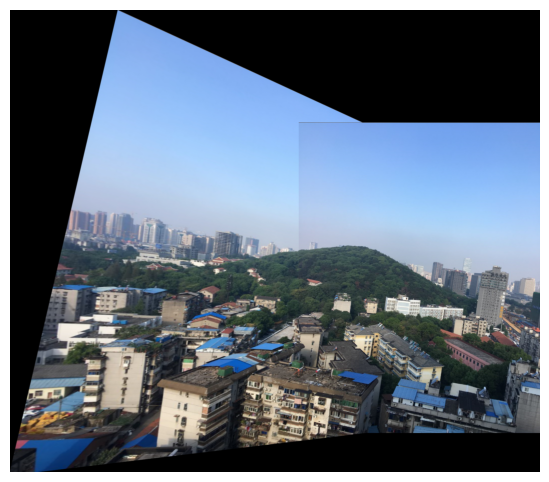

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取6张图像
image_files =  ["./map1.png","./map2.png"]
images = [cv2.imread(file) for file in image_files]

# 初始化SIFT特征检测器
sift = cv2.SIFT_create()

# 暴力匹配器初始化，使用欧氏距离
bf = cv2.BFMatcher(cv2.NORM_L2)

def stitch_images(img1, img2):
    # 转换为灰度图像
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # 检测关键点和描述符
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # 进行暴力匹配
    matches = bf.knnMatch(des1, des2, k=2)
    goods_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            goods_matches.append(m)
            
    if len(goods_matches) >= 4:   

        # 提取匹配的关键点
        src_pts = np.float32([kp1[m.queryIdx].pt for m in goods_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in goods_matches]).reshape(-1, 1, 2)
    
        # 计算单应性矩阵（使用RANSAC算法去除误匹配）
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    else:
        print('not enough point number to compute homography matrix')
        exit()

    # 计算拼接后的尺寸（基于透视变换的结果）
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    
    pts1 = np.float32([[0, 0], [0, h1 - 1], [w1 - 1, h1 - 1], [w1 - 1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2 - 1], [w2 - 1, h2 - 1], [w2 - 1, 0]]).reshape(-1, 1, 2)

    # 透视变换后的点
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)

    # 计算拼接后的新尺寸边界
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)

    # 平移矩阵，确保图像不会有负坐标
    translation_dist = [-xmin, -ymin]
    H_translation = np.array([[1, 0, -xmin], [0, 1, -ymin], [0, 0, 1]])

    # 对第一张图像进行仿射变换
    result = cv2.warpPerspective(img1, H_translation.dot(H), (xmax - xmin, ymax - ymin))
    # 将第二张图像复制到拼接结果中
    result[-ymin:-ymin+h2, -xmin:-xmin+w2] = img2

    return result

# 依次拼接多张图像
stitched_image = images[0]
for i in range(1, len(images)):
    stitched_image = stitch_images(stitched_image, images[i])

# 显示最终拼接结果
plt.figure(figsize=[12,6])
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


### 虚拟计算器项目

In [46]:
# 创建button类
class Button:
    def __init__(self, pos, width, height, value):
        self.pos = pos
        self.width = width
        self.height = height
        self.value = value
        
    def draw(self, img):
        # 绘制一个计算器的小格子
        # 先画一个实心的灰色矩形
        cv2.rectangle(img, (self.pos[0], self.pos[1]), (self.pos[0] + self.width, self.pos[1] + self.height), (225, 225, 225), -1)
        # 再画矩形的边框
        cv2.rectangle(img, (self.pos[0], self.pos[1]), (self.pos[0] + self.width, self.pos[1] + self.height), (0, 0, 0), 3)
        cv2.putText(img, self.value, (self.pos[0] + 30, self.pos[1] + 70), cv2.FONT_HERSHEY_PLAIN, 2, (50, 50, 50), 2)
        
    def check_click(self, x, y):
        if self.pos[0] < x < self.pos[0] +self.width and self.pos[1] < y < self.pos[1] + self.height:
            cv2.rectangle(img, (self.pos[0] + 3, self.pos[1] + 3), 
                         (self.pos[0] + self.width -3, self.pos[1]+self.height -3),
                        (255, 255, 255), -1)
            cv2.putText(img, self.value, (self.pos[0]+25, self.pos[1] + 80), cv2.FONT_HERSHEY_PLAIN, 5, (0, 0, 0), 5)
            return True
        else:
            return False

In [55]:
# 从打开摄像头, 显示每一帧图片开始
import numpy as np
import cv2
from cvzone.HandTrackingModule import HandDetector
import time

# 需要安装cvzone和mediapipe
# pip install cvzone mediapipe -i https://pypi.douban.com/simple

cap = cv2.VideoCapture(0)
# 设置窗口大小.
cap.set(3, 1280)
cap.set(4, 720)

button_values = [['7', '8', '9', '*'],
                 ['4', '5', '6', '-'],
                 ['1', '2', '3', '+'],
                 ['0', '/', '.', '=']]

button_list = []
for x in range(4):
    for y in range(4):
        x_pos = x * 100 + 800
        y_pos = y * 100 + 150
        button = Button((x_pos, y_pos), 100, 100, button_values[y][x])
        button_list.append(button)

# 创建hand detector
detector = HandDetector(maxHands=1, detectionCon=0.8)

my_equation = ''

while True:
    flag, img = cap.read()
    # 摄像头显示的画面和真实画面反掉了.
    img = cv2.flip(img, 1)
    if flag:
        for button in button_list:
            button.draw(img)
            
        # 创建显示结果的窗口
        cv2.rectangle(img, (800, 70), (800 + 400, 70 + 100), (225, 225, 225), -1)
        cv2.rectangle(img, (800, 70), (800 + 400, 70 + 100), (50, 50, 50), 3)
        
        # 检测手
        hands, img = detector.findHands(img, flipType=False)
#         print(hands)
        if hands:
            # 取出食指和中值的点, 计算两者的距离
            lmlist = hands[0]['lmList']
            length, _, img = detector.findDistance(lmlist[8], lmlist[12], img)
#             print(length, _, img)
#             print(length)
            # 取出手指的坐标
            x, y = lmlist[8]
        
        # 根据食指和中指之间的距离, 如果小于50, 我们认为是进行了点击操作.
        if length < 50:
            for i, button in enumerate(button_list):
                if button.check_click(x, y):
                    # 说明是一个正确点击. 应该要把点中的数字显示在窗口上. 
                    my_value = button_values[int(i % 4)][int(i / 4)]
                    # 如果是'=', 说明要计算了.
                    if my_value == '=':
                        my_equation = str(eval(my_equation))
                    else:
                        # 字符串的拼接
                        my_equation += my_value
                        time.sleep(0.1)
        
        cv2.putText(img, my_equation, (810, 130), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 0), 3)
        cv2.imshow('img', img)
        key = cv2.waitKey(1)
        if key == ord('q'):
            break
        elif key == ord('c'):
            # 清空输出框
            my_equation = ''
    else:
        print('摄像头打开失败')
        break
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
# 课后思考:
1. 如何解决手被计算器边缘挤压的问题.
2. 如何解决点击数字重复出现问题.


In [42]:
s = '9 + 3'
eval(s)

12